<a href="https://colab.research.google.com/github/LuisKolb/MachineLearningWS21/blob/main/ex3_moviereviews_univ_sentence_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Reviews Classification with DL
adapted from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb

In [1]:
# if running in colab uncomment the following:

#!pip install tensorflow-hub
#!pip install tensorflow-datasets

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
# This might be necessary if runiing locally, depending on your machine's hardware

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [4]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3VJJ9O/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3VJJ9O/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3VJJ9O/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(512)))
#train_examples_batch
#train_labels_batch

In [6]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
#hub_layer(train_examples_batch[:3])

In [7]:
# helper functions

def epoch_plots(history):
  plt.figure(figsize =(5,3))
  plt.plot(history.history['loss'], marker='.', label='train')
  plt.plot(history.history['val_loss'], marker='.', label='validation')
  plt.title('Loss')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize =(5,3))
  plt.plot(history.history['accuracy'], marker='.', label='train')
  plt.plot(history.history['val_accuracy'], marker='.', label='validation')
  plt.title('Accuracy')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(loc='best')
  plt.show()

## Basic Models
These are very basic Layer designs to get a baseline reading before further tuning.

### CNN

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 52s 1s/step - loss: 0.5761 - accuracy: 0.6375 - val_loss: 0.4256 - val_accuracy: 0.8077
Epoch 2/10
30/30 [==============================] - 41s 1s/step - loss: 0.2793 - accuracy: 0.9018 - val_loss: 0.3157 - val_accuracy: 0.8495
Epoch 3/10
30/30 [========

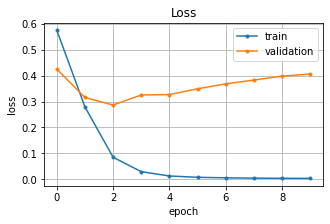

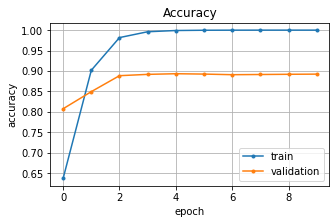

In [9]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['accuracy'], marker='.', label='train')
plt.plot(history.history['val_accuracy'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [10]:
# depending on your GPU-RAM you might need to clear the model out of memory to avoid OOM-errors
del model

### RNN

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((512, 1)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 reshape (Reshape)           (None, 512, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,798,993
Trainable params: 256,798,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 52s 1s/step - loss: 0.6855 - accuracy: 0.5007 - val_loss: 0.6800 - val_accuracy: 0.4990
Epoch 2/10
30/30 [==============

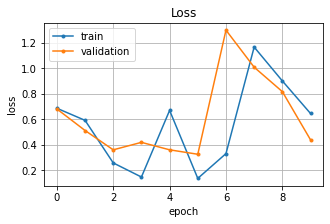

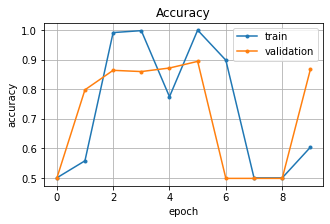

In [12]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['accuracy'], marker='.', label='train')
plt.plot(history.history['val_accuracy'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [13]:
del model

We get about **0.85 to 0.87 acurracy** with just very basic networks. Let's see if we can do a little better.

## Fine-tuned Networks

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

### CNN
Here we add a dropout layer to avoid overfitting.

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)

model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,321
Trainable params: 256,806,32

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 46s 1s/step - loss: 0.4284 - accuracy: 0.9646 - val_loss: 0.3573 - val_accuracy: 0.8934
Epoch 2/10
30/30 [==============================] - 40s 1s/step - loss: 0.1368 - accuracy: 0.9997 - val_loss: 0.3021 - val_accuracy: 0.8963
Epoch 3/10
30/30 [==============================] - 40s 1s/step - loss: 0.0420 - accuracy: 0.9997 - val_loss: 0.3475 - val_accuracy: 0.8958
Epoch 4/10
30/30 [==============================] - 40s 1s/step - loss: 0.0184 - accuracy: 0.9998 - val_loss: 0.3986 - val_accuracy: 0.8960
Epoch 5/10
30/30 [==============================] - 40s 1s/step - loss: 0.0116 - accuracy: 0.9997 - val_loss: 0.4438 - val_accuracy: 0.8956
Epoch 6/10
30/30 [==============================] - 40s 1s/step - loss: 0.0083 - accuracy: 0.9997 - val_loss: 0.4823 - val_accuracy: 0.8954
Epoch 7/10
30/30 [==============================] - 40s 1s/step - loss: 0.0062 - accuracy: 0.9998 - val_loss: 0.5158 - val_accuracy: 0.8958
Epoch 8/10
30/30 [=============

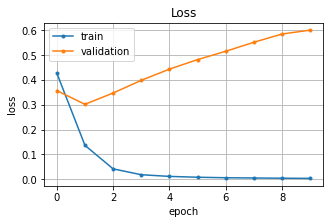

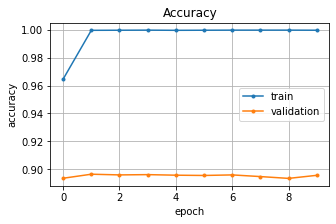

In [17]:
epoch_plots(history)

In [18]:
del model

### RNN

In [19]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Reshape((512, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 reshape_1 (Reshape)         (None, 512, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 512, 128)         33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

Epoch 1/10
30/30 [==============================] - 68s 2s/step - loss: 0.4820 - accuracy: 0.6709 - val_loss: 0.2850 - val_accuracy: 0.8712
Epoch 2/10
30/30 [==============================] - 54s 2s/step - loss: 0.0165 - accuracy: 0.9981 - val_loss: 0.5622 - val_accuracy: 0.8930
Epoch 3/10
30/30 [==============================] - 54s 2s/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.7744 - val_accuracy: 0.8905
Epoch 4/10
30/30 [==============================] - 54s 2s/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.7795 - val_accuracy: 0.8906
Epoch 5/10
30/30 [==============================] - 54s 2s/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.8790 - val_accuracy: 0.8954
Epoch 6/10
30/30 [==============================] - 54s 2s/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.8994 - val_accuracy: 0.8948
Epoch 7/10
30/30 [==============================] - 54s 2s/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.7360 - val_accuracy: 0.8969
Epoch 8/10
30/30 [==

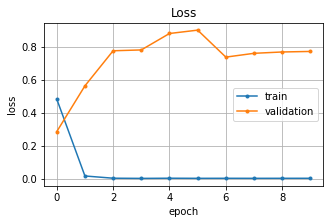

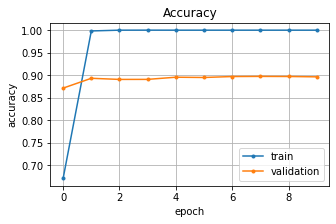

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))
epoch_plots(history)